In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling
%matplotlib inline

Get data

In [2]:
data=pd.read_csv('advertising.csv')
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


No. of rows and columns

In [4]:
data.shape

(200, 4)


Information about data like data types and missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


Observations

In [6]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


No missing values

In [8]:
data.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

No duplicated values

In [9]:
data.duplicated().sum()

0

In [10]:
data.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales'], dtype='object')

Data Visualization

In [11]:
fig=px.scatter(data,x='TV',y='Sales')
fig.show()

In [12]:
fig=px.scatter(data,x='Radio',y='Sales')
fig.show()

In [13]:
fig=px.scatter(data,x='Newspaper',y='Sales')
fig.show()

Only Newspaper column has outliers values

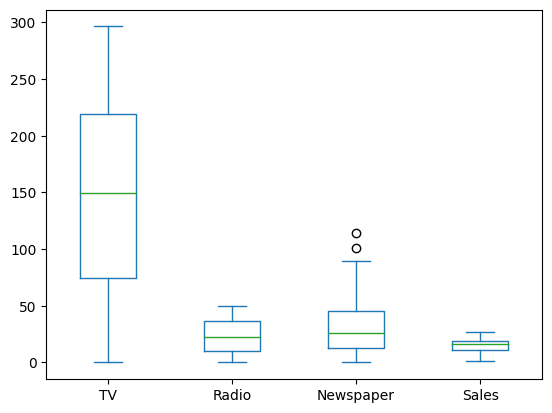

In [15]:
data.plot(kind='box');

Dealing with outlier

In [16]:
outlier_percentage = {}
for feature in data.columns:
    tempData = data.sort_values(by=feature)[feature]
    Q1, Q3 = tempData.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    Lower_range = Q1 - (1.5 * IQR)
    Upper_range = Q3 + (1.5 * IQR)
    outlier_percentage[feature] = round((((tempData<(Q1 - 1.5 * IQR)) | (tempData>(Q3 + 1.5 * IQR))).sum()/tempData.shape[0])*100,2)
outlier_percentage

{'TV': 0.0, 'Radio': 0.0, 'Newspaper': 1.0, 'Sales': 0.0}

Drop outlier

In [17]:
outlier = data[(data[feature]>Lower_range) & (data[feature]<Upper_range)].reset_index(drop=True)

In [23]:
corr=data.corr()
fig = px.imshow(corr, text_auto=True,width=1000, height=1000)
fig.show()

In [19]:
X=data.drop('Sales',axis=1)
y=data['Sales']

feature selection

In [20]:
from sklearn.ensemble import ExtraTreesRegressor
ex=ExtraTreesRegressor()
ex.fit(X,y)

ExtraTreesRegressor()

In [21]:
ex.feature_importances_

array([0.84668612, 0.1380301 , 0.01528378])

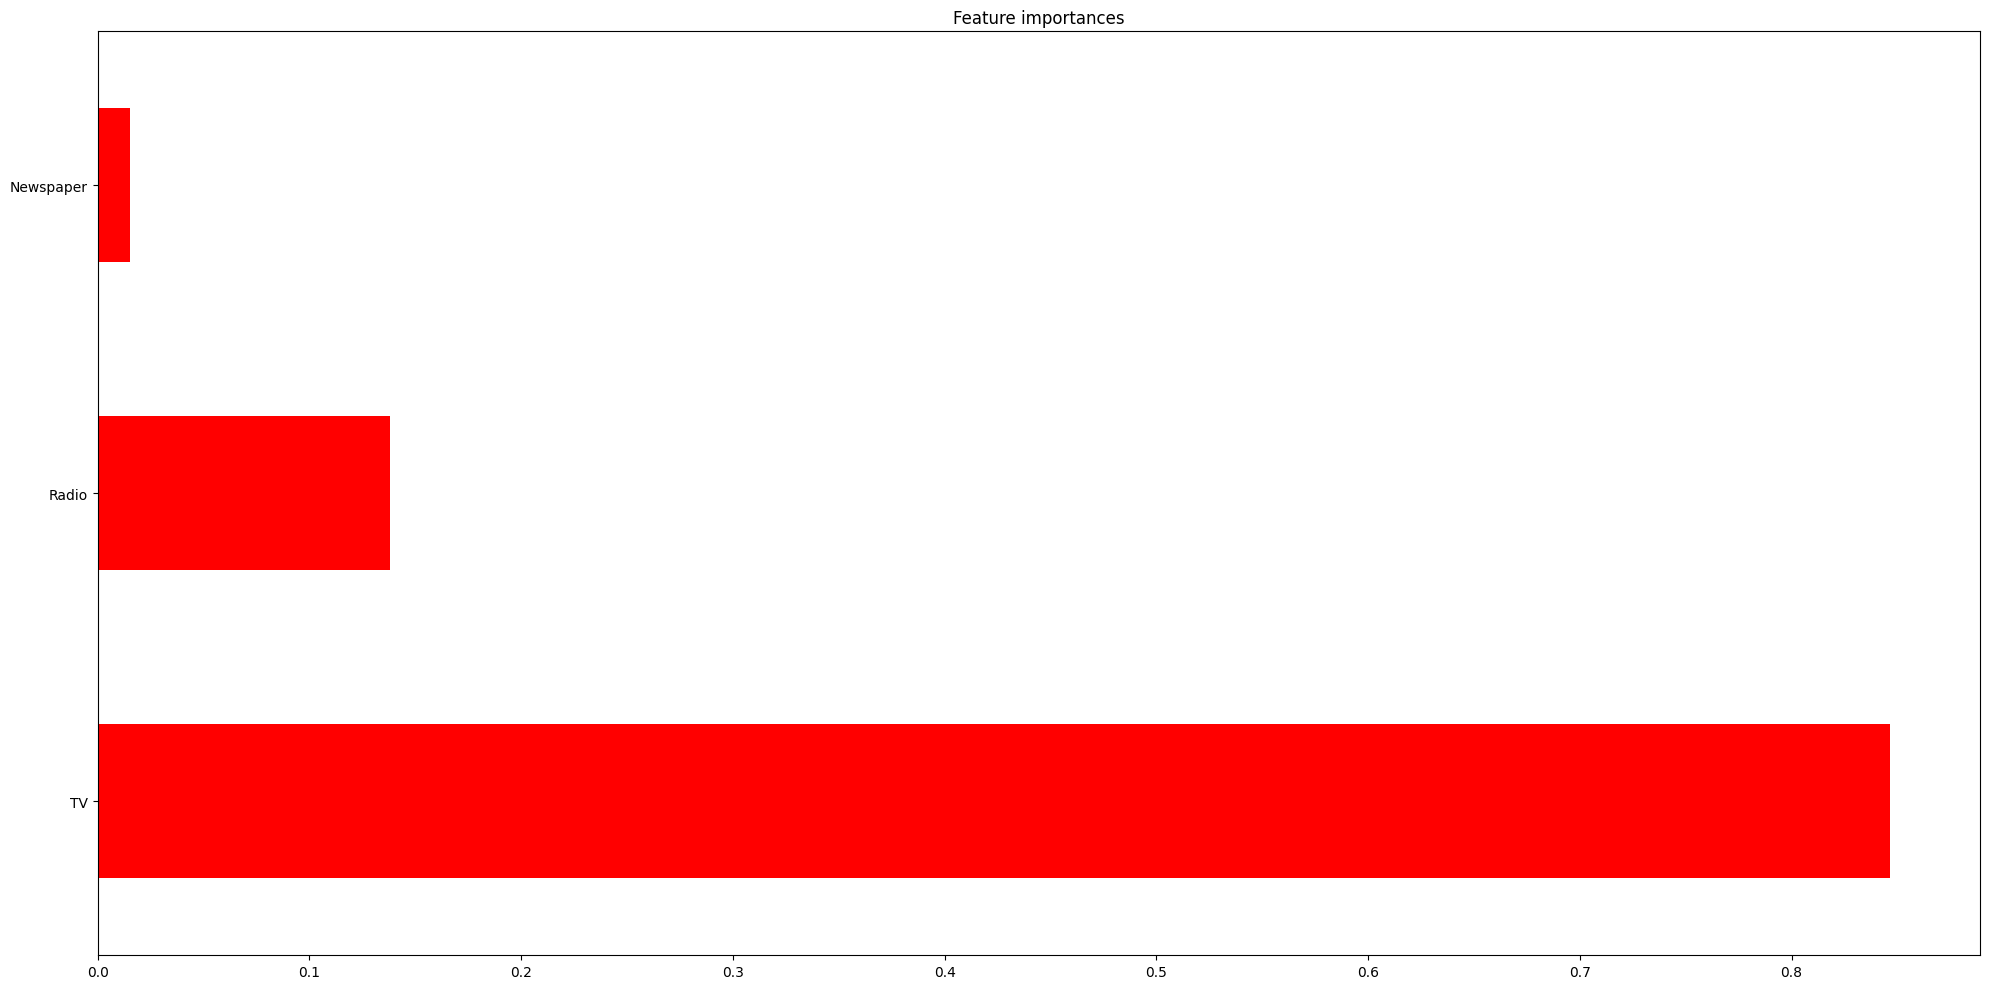

In [22]:
plt.figure(figsize=(20,10))
plt.title('Feature importances')
feat=pd.Series(ex.feature_importances_,index=X.columns)
feat.nlargest(12).plot(kind='barh', color="r", align="center")
plt.tight_layout()
plt.grid(False)
plt.show()

In [24]:
X.drop(['Newspaper'],axis=1,inplace=True)

In [25]:
from sklearn.model_selection import train_test_split ,cross_val_score,RandomizedSearchCV
X_train ,X_test,y_train ,y_test =train_test_split(X,y,test_size =.2,random_state=0)

Scaling

In [26]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

**ML**

In [27]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression ,SGDRegressor,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from xgboost.sklearn import XGBRegressor

In [28]:
models = {'Linear Regression = ': LinearRegression(),
         'Lasso = ': Lasso(),
         'Decision Tree = ': DecisionTreeRegressor(),
         'Random Forest = ': RandomForestRegressor(),
         'Gradient Boosting = ':GradientBoostingRegressor(),
         'Ridge = ': Ridge(),
         'Stochastic Gradien Descent = ': SGDRegressor(),
         'Elastic = ': ElasticNet(),
         'xgb Regressor = ': XGBRegressor()}

In [29]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='neg_mean_squared_error',
                                            cv=3
                                            ).mean()

    return model_scores

xgb Regressor won !!

In [30]:
model_scores = fit_score(models,X_train,X_test,y_train,y_test)

model_scores

{'Linear Regression = ': -5.795895397831813,
 'Lasso = ': -7.391402016450852,
 'Decision Tree = ': -5.8634615384615385,
 'Random Forest = ': -4.335691902930403,
 'Gradient Boosting = ': -3.7425483013222896,
 'Ridge = ': -5.747389888546077,
 'Stochastic Gradien Descent = ': -5.9111365454293106,
 'Elastic = ': -9.855679007180411,
 'xgb Regressor = ': -3.47746546166212}

In [31]:
vot=VotingRegressor([('LinearRegression',LinearRegression()),('DecisionTrees',DecisionTreeRegressor()),('LassoRegression',Lasso()),
                     ('RandomForest',RandomForestRegressor()),('ElasticNet',ElasticNet()),
                     ('StochasticGradientDescent',SGDRegressor()),
                    ('GrafientBoosting',GradientBoostingRegressor()),('Ridge',Ridge()),('xgb',XGBRegressor())])
vot.fit(X_train,y_train)
y_pred=vot.predict(X_test)

In [32]:
mean_squared_error(y_test,y_pred)

5.973099607478166

hyperparameter tuning

In [33]:
np.random.seed(42)
## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
params = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    }

xr = RandomizedSearchCV(XGBRegressor(),
                        param_distributions=params,
                        cv=3,
                        n_iter=30,
                        verbose=0,
                        n_jobs=-1
                        )

xr.fit(X_train, y_train)

xr.best_params_

{'n_estimators': 500,
 'min_child_weight': 2,
 'max_depth': 10,
 'learning_rate': 0.05,
 'booster': 'gbtree'}

In [34]:
xr.best_estimator_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
xr.best_score_

0.9434120952773787

In [36]:
xr.score(X_test, y_test)

0.8195512071683531

In [37]:
model = XGBRegressor(n_estimators=500,min_child_weight=2,max_depth=10,learning_rate=0.05,booster='gbtree')
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)

In [38]:
r2_score(y_pred1,y_test)

0.7426822164897924